# Stochastic Simulations - group project

## Project 4 : Variance reduction in Monte Carlo integration via function approximation

Francesca Bettinelli \
Marianna Dell'Otto \
Sophie Lequeu

In [1]:
from question2 import *
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Question 1
See LaTeX report.

### Question 2
#### a) Crude Monte Carlo estimator
We begin by estimating the integral *$I$* using a crude Monte Carlo estimator *$I_{MC}$*.

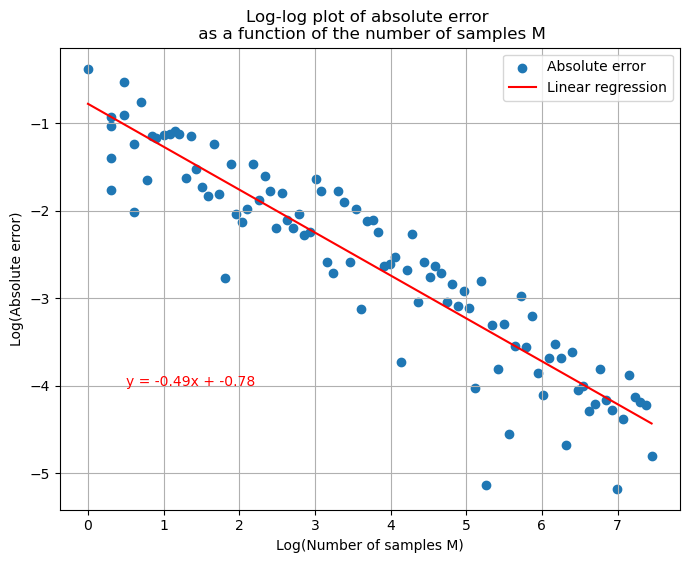

In [12]:
# exact value of the integral (reference)
ref_value = (1/5) * np.arctan(5)

# crude Monte Carlo estimators
N = 100
nb_samples = [math.ceil(np.power(2, 1/4)**n) for n in range(N)]
CMC_estims = np.zeros(N)
for M in range(N):
    unif_samps = np.random.uniform(0, 1, nb_samples[M])
    CMC_estims[M] = crude_MC(unif_samps, f)

# plot log-log graph to see order of the error
loglog_graph(nb_samples, CMC_estims, ref_value)


Plotting the error of the crude Monte Carlo estimator for different values of M (in log-log scale), we observe that it can be approximated by a straight line with slope $\approx 0.5$. We conclude that the error decreases approximately as the square-root of the number of samples M. This is indeed what was expected from a crude Monte Carlo estimator, since it is unbiaised, with variance in $\mathcal{O}(M)$, thus confidence interval in $\mathcal{O}(\sqrt M)$ (from the CLT).

#### b) MCLS
The aim of this second part is to implement the MCLS estimators *$I_{MCLS}$* using an expansion of the Legendre polynomials up to degree n.
We will consider the same values of $M$ (numbers of samples) as in *(a)*, and try different values of $n$ : \
    $n = 1, 2, ...$, \
    $n = \lceil \sqrt M \rceil$, \
    $n = \lceil \frac{M}{2} \rceil$.

In [23]:
ref_value = (1/5) * np.arctan(5)
N = 240
nb_samples = [math.ceil(np.power(2, 1/16)**n) for n in range(N)]

trials_n = [1, 20, -1]
nb_trials_n = len(trials_n)

# MCLS estimators
MCLS_estims = [np.zeros(N) for _ in range(nb_trials_n)]
MCLS_prime_estims = [np.zeros(N) for _ in range(nb_trials_n)]

for M in range(N):
    for i in range(nb_trials_n):
        n = trials_n[i]

        if n==-1:
            n=np.ceil(np.sqrt(nb_samples[M])).astype(int)
        if n==-2:
            n=np.ceil((nb_samples[M])/2).astype(int)
            
        unif_samps = np.random.uniform(0, 1, nb_samples[M])
        MCLS_estims[i][M] = MCLS(unif_samps, f,  n)
        MCLS_prime_estims[i][M] = MCLS_prime(unif_samps, f)
    

n =  1
Condition number of the Vandermonde matrix :  1.0
n =  20
Condition number of the Vandermonde matrix :  1.0
n =  1
Condition number of the Vandermonde matrix :  1.0
n =  1
Condition number of the Vandermonde matrix :  2.0647481940351877
n =  20
Condition number of the Vandermonde matrix :  10.573043515737735
n =  2
Condition number of the Vandermonde matrix :  2.8067692602271452
n =  1
Condition number of the Vandermonde matrix :  24.834187912903985
n =  20
Condition number of the Vandermonde matrix :  1.7377056417388383
n =  2
Condition number of the Vandermonde matrix :  2.9408687590267264
n =  1
Condition number of the Vandermonde matrix :  2.4164980448299187
n =  20
Condition number of the Vandermonde matrix :  1.457337896871204
n =  2
Condition number of the Vandermonde matrix :  2.095924283275613
n =  1
Condition number of the Vandermonde matrix :  2.9243806189519
n =  20
Condition number of the Vandermonde matrix :  1.886495119305237
n =  2
Condition number of the Vanderm

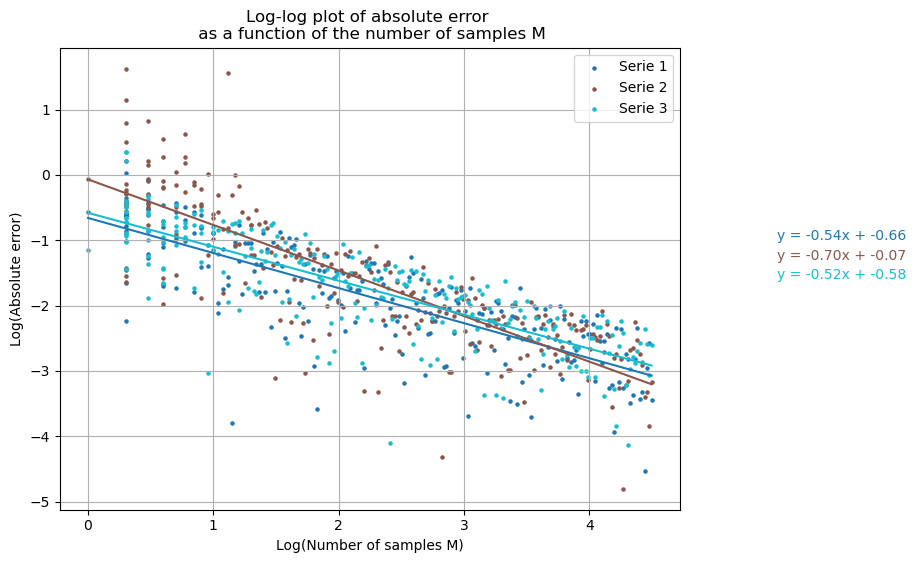

In [24]:
# plot log-log graph to see order of the error
multiple_loglog_graph(nb_samples, MCLS_estims, ref_value)

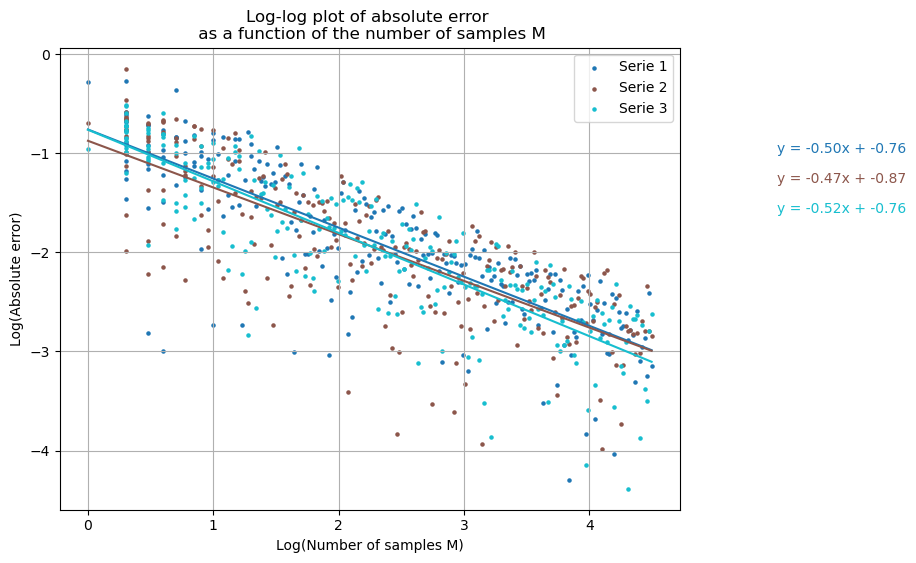

In [22]:
# plot log-log graph to see order of the error
multiple_loglog_graph(nb_samples, MCLS_prime_estims, ref_value)

In [6]:
ref_value = (1/5) * np.arctan(5)
N = 60
nb_samples = [math.ceil(np.power(2, 1/4)**n) for n in range(N)]

# MCLS estimators
MCLS_estims = np.zeros(N)
MCLS_prime_estims = np.zeros(N)

for M in range(N):
    n=1
    #n = np.ceil(np.sqrt(nb_samples[M])).astype(int)
    unif_samps = np.random.uniform(0, 1, nb_samples[M])
    MCLS_estims[M] = MCLS_new(unif_samps, f, n)
    MCLS_prime_estims[M] = MCLS_prime_new(unif_samps, f)

c:\Users\Lenovo\anaconda3\lib\site-packages\numpy\polynomial\legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


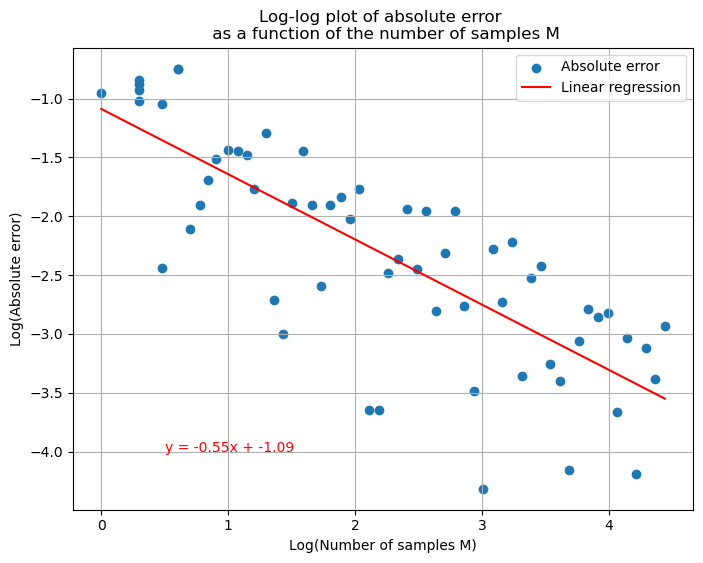

In [7]:
# plot log-log graph to see order of the error
loglog_graph(nb_samples, MCLS_estims, ref_value)

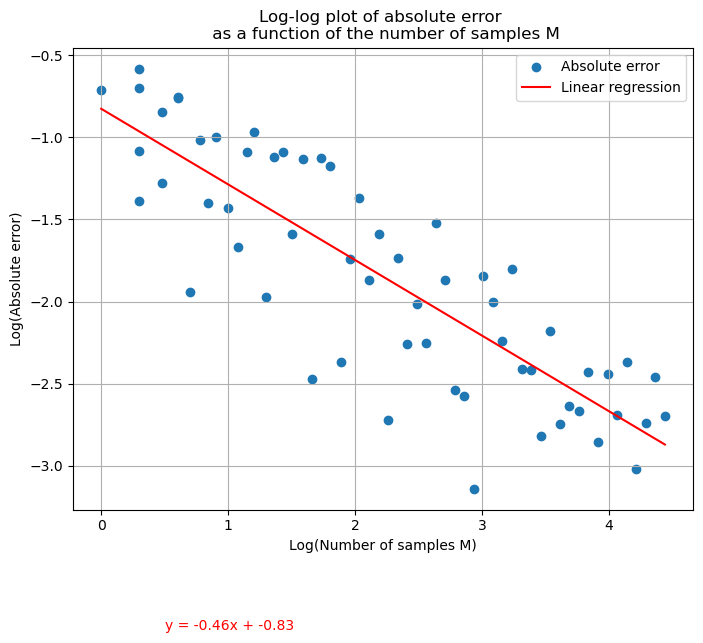

In [8]:
# plot log-log graph to see order of the error
loglog_graph(nb_samples, MCLS_prime_estims, ref_value)

### Question 3
In this question, we propose an expression for $I_{MCLS}$ and $I_{MCLS}'$ generalized to the case of importance sampling. Samples $x^{(i)}$'s are now drawn from a distribution defined by the probability density function $g(x) = \frac{1}{w(x)}$.
We propose : 
$$I_{IS-MCLS} = \frac{\sum_{i=1}^M \left(f(x^{(i)}) - \sum_{j=0}^n c_j^{**} \phi_j(x^{(i)})\right) w(x^{(i)})}{\sum_{i=1}^M w(x^{(i)})} + c_0^{**}$$ 
and 
$$I_{IS-MCLS}' = c_0^{**}$$ 

where $\textbf{c**} = \argmin_{\textbf{c} \in \mathbb{R}^{n+1}} \sum_{i=1}^M w(x^{(i)}) \left(f(x^{(i)}) - \sum_{j=0}^n c_j \phi_j (x^{(i)}) \right)^2$

as generalized estimators IS-MCLS and IS-MCLS'. \
In the LaTeX report, we verify that these verify the properties stated in Question 1 for classical $I_{IS-MCLS}$ and $I_{IS-MCLS}'$ estimators.

### Question 4
- Propose a method to sample from the density $h(x) := \frac{1}{w(x)}$ : \
We will be using the Acceptance-rejection method. This method is the one proposed in ref [2], page 6, where we only consider the case where function f has values in $R$ (and not $R^d$). Briefly :
    1.  We need a bound on the true propability density function. Knowing that every $\phi_j^2$ can be bounded by $4 e p_1^{\infty}(x)$, $h(x)$ can be bounded by the same quantity. We denote $g(x) = p_1^{\infty}(x)$ (our bound, without the multiplicative constant).
    2.  Then we sample $Y$ from this bound $g(x)$. Since this bound has a nice expression, this can be done by Inverse transform method.
    3.  We sample $U$ from uniform on $[0, 1]$, independant of $Y$.
    4.  If $U \leq \frac{h(Y)}{g(Y)} $, set $X=Y$, otherwise return to step 2.

- Implement the MCLS estimators with importance sampling.
- Test on same number of samples as in Question 2. 
